# Ultrasonic Temporal Interference for neuromodulation
### On the feasibility of using temporally interfering ultrasonic fields for intramembrane cavitation and neuro-stimulation

## Rationale

Surface acoustic wave (SAW) transducers are a very appealing technology for in-vitro US neuromodulation experiments, as they can be embedded “seamlessly” with cultured neurons in a Petri dish, and easily coupled with recording equipment.

Unfortunately, the ultrasound frequencies they generate are in the order of tens of MHz, which is far above our working range of interest. In fact, the theoretical model we wish to validate is based on cavitation, which is much more prominent at lower (sub-MHz) frequencies. 

However, we imagined that we could maybe couple two ultrasound sources of very similar high frequencies differing only by a few hundreds of kHz (e.g. $f_1$ = 50.0 MHz and $f_2$ = 50.5 MHz). According to the acoustic superposition principle, the interaction of those two waves would create an alternation of constructive and destructive interference. This should generate a low frequency oscillatory envelope at $f_{env} = \frac{f_2 – f_1}{2}$, which may in turn induce the desired cavitation effect, and ultimately depolarize the membrane. 

I ran some preliminary simulations of my model to test those predictions. Early results (see attached figure) show that the interference of two high-frequency waves of equal amplitude can generate a low-frequency envelope of cavitation in the neuron membrane in order to induce depolarization.
Furthermore, by modulating the ratio of intensity of the two high-frequency sources, we can induce an offset in the cavitation envelope, which enhances the depolarization efficiency to values that can exceed those obtained with a single low-frequency source.

### Imports

In [1]:
%matplotlib inline
import logging
import os
import numpy as np
from scipy import signal as sg
import matplotlib.pyplot as plt

from PySONIC.neurons import getPointNeuron
from PySONIC.core import BilayerSonophore, AcousticDrive, AcousticDriveArray
from PySONIC.utils import logger

logger.setLevel(logging.INFO)
figs, Vm_devs = {}, {}

### Functions

In [2]:
def plotResponse(bls, drive, label, Qm=None):
    ''' Simulate the model for a specific mechanical drive and
        plot the resulting deflection profile.

        :param bls: BilayerSonophore model object
        :param drive: acoustic drive object
        :param label: label for the acoustic drive
        :param Qm: imposed charge density (C/m2)
        :return: 2-tuple with figure object and average voltage deviation
    '''
    if Qm is None:
        Qm = bls.Qm0

    # Simulate and extrat output
    logger.info(f'Simulating {bls} model with {drive}')
    data = bls.simCycles(drive, Qm, n=3)
    t, Z = [data[k].values for k in ['t', 'Z']]
    Pac = drive.compute(t)

    # Compute the average voltage deviation per cycle
    Cm = bls.v_capacitance(Z)         # F/m2
    Vm = Qm / Cm * 1e3                # mV
    Vm0 = bls.Qm0 / bls.Cm0 * 1e3     # mV
    avg_delta_Vm = np.mean(Vm0 - Vm)  # mV

    # Plot pressure and deflection time profiles
    fig, axes = plt.subplots(2, 1)
    fig.suptitle(f'{label} US ({drive.desc})')
    ax = axes[0]
    ax.set_ylabel('Pac (kPa)')
    if isinstance(drive, AcousticDriveArray):
        Penv = np.abs(sg.hilbert(Pac))
        for k, s in drive.drives.items():
            ax.plot(t * 1e6, s.compute(t) * 1e-3, label=k, alpha=0.5)
        ax.plot(t * 1e6, Pac * 1e-3, label='sum', c='k', alpha=0.5)
        ax.plot(t * 1e6, Penv * 1e-3, '--', c='k', label='envelope')
        ax.plot(t * 1e6, -Penv * 1e-3, '--', c='k')
        ax.legend()
    else:
        ax.plot(t * 1e6, Pac * 1e-3, c='k')
    ax = axes[1]
    ax.set_ylim(-1, 6)
    ax.set_xlabel('time (us)')
    ax.set_ylabel('deflection (nm)')
    ax.plot(t * 1e6, Z * 1e9, c='k')

    return fig, avg_delta_Vm

## Standard bilayer sonophore model (no high-frequency damping)

Let's define a typical, 32 nm radius bilayer sonophore model with the resting charge density of a regular spiking neuron.

In [3]:
pneuron = getPointNeuron('RS')
a = 32e-9             # m
Cm0 = pneuron.Cm0     # F/m2
Qm0 = pneuron.Qm0     # Q/m2
bls = BilayerSonophore(a, Cm0, Qm0)

Let's also define a constant peak pressure amplitude of 100 kPa, conserved across all acoustic drives.

In [4]:
peak_pressure = 100e3  # Pa

## Standard sources

Let's start by evaluating the model's response simple acoustic sources oscillating at a single frequency.

### Low-frequency drive

We first test the model behavior with a low-frequency drive at 500 kHz (i.e. within the working range of our model) 

 10/02/2020 19:55:35: Simulating BilayerSonophore(32.0 nm) model with AcousticDrive(500.0kHz, 100.0kPa)


Average voltage deviation from resting potential: 64.91 mV


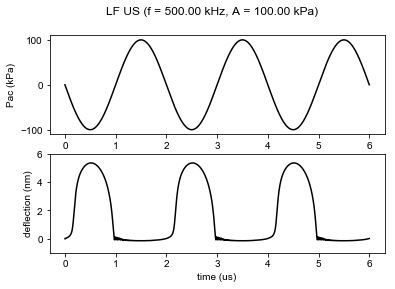

In [5]:
f_low = 500e3  # Hz
label = 'LF'
drive = AcousticDrive(f_low, peak_pressure)
figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

As expected, the membrane cavitates in resonance with the acoustic drive, with a deflection maximum around 5.5 nm. Overall this cavitation creates an average voltage deviation of 64 mV from the membrane's resting potential.

### High-frequency drive

We now test the model behavior with a high-frequency drive at 50 MHz (i.e. outside of the model's expected working range, but inside the range of action of SAW transducers)

 10/02/2020 19:55:37: Simulating BilayerSonophore(32.0 nm) model with AcousticDrive(50.0MHz, 100.0kPa)


Average voltage deviation from resting potential: 19.00 mV


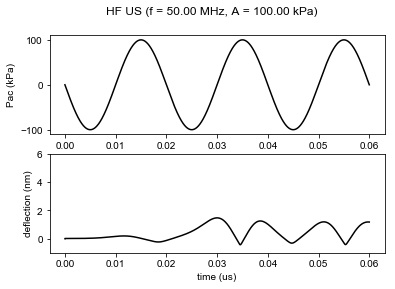

In [6]:
f_high = 50e6  # Hz
label = 'HF'
drive = AcousticDrive(f_high, peak_pressure)
figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

As expected, the membrane cannot mechanically follow the high frequency oscillations, and it results a low amplitude, non-periodic deflection profile with a maximum around 3 nm. This only creates an average voltage deviation of 19 mV from the membrane's resting potential (i.e. around 30 % of what the LF drive generates).

## TI sources

Let's now look at the impact of 2 high-frequency drives whose frequencies are $f_{high} - f_{low}/2$ and $f_{high} + f_{low}/2$, i.e. centered around the high-frequency drive and differing only by the low-frequency drive used above.

Due to the acoustic superposition principle, these two drives will create a high-frequency drive at $f_{drive} = \frac{f_1 + f_2}{2}$, modulated by a low-frequency envelope oscillating at $f_{env} = f2 - f1$.

Moreover, let us introduce a phase offset of $\pi$ between the two drives that will ensure that they start with a fully destructive interference.

In [7]:
f1 = f_high - f_low / 2  # Hz
f2 = f_high + f_low / 2  # Hz
fenv = f2 - f1  # Hz
delta_phi = np.pi  # rad
print(f'f1 = {f1 * 1e-6:.2f} MHz, f2 = {f2 * 1e-6:.2f} MHz, fenv = {fenv * 1e-3:.2f} kHz')

f1 = 49.75 MHz, f2 = 50.25 MHz, fenv = 500.00 kHz


Let us also define a function to define amplitude pairs for different ratios, while ensuring a constant peak pressure amplitude

In [8]:
def getAmpPair(total, ratio):
    ''' Return two numbers that sum up to a specific value, with a specific ratio. '''
    x1 = total / (1 + ratio)
    return x1, x1 * ratio

### 1:1 TI ratio

Let's start with 2 sources of equal amplitude (50 kPa each, summing up to 100 kPa during full constructive interference)

 10/02/2020 19:55:38: Simulating BilayerSonophore(32.0 nm) model with AcousticDriveArray(AcousticDrive(49.8MHz, 50.0kPa), AcousticDrive(50.2MHz, 50.0kPa))


Average voltage deviation from resting potential: 40.64 mV


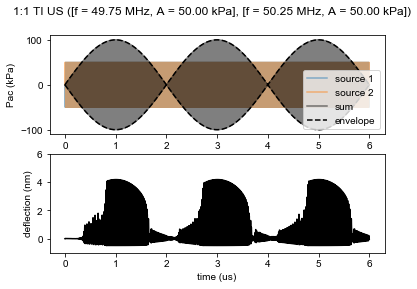

In [9]:
k = 1
label = f'1:{k} TI'
A1, A2 = getAmpPair(peak_pressure, k)
drive = AcousticDriveArray([AcousticDrive(f1, A1, phi=np.pi), AcousticDrive(f2, A2, phi=np.pi - delta_phi)])
figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

As we can see, the membrane seems to enter into some sort of resonance with the combined high frequency drive (probably as a result of its asymmetry). Additionally, we notice the appearance of a low-frequency cavitation envelope that matches that of the acoustic drive. 

As a result, the membrane deflection can reach up to 4 nm (compared to 3nm with a single HF drive), which effectively doubles the resulting average voltage deviation from the membrane resting potential.

### 1:2 TI ratio

Let's now change the sources amplitudes such that the second one is twice the first one (i.e. 33 and 66 kPa respectively, also summing up to 100 kPa during full constructive interference).

 10/02/2020 19:56:15: Simulating BilayerSonophore(32.0 nm) model with AcousticDriveArray(AcousticDrive(49.8MHz, 33.3kPa), AcousticDrive(50.2MHz, 66.7kPa))


Average voltage deviation from resting potential: 42.68 mV


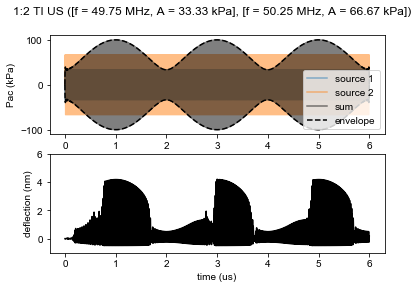

In [10]:
k = 2
label = f'1:{k} TI'
A1, A2 = getAmpPair(peak_pressure, k)
drive = AcousticDriveArray([AcousticDrive(f1, A1, phi=np.pi), AcousticDrive(f2, A2, phi=np.pi - delta_phi)])
figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

Expectedly, since full destructive interference between the two sources is never fully achieved because of the amplitude imbalance, we observe an an offset in the absolute value of the drive low-frequency envelope.

Interestingly, this offset is perpetuated into the membrane deflection profile, where the compression amplitudes are reduced.

As a result, while the membrane deflection reaches the same maximum of 4 nm, the deflection offset during compression phases amplifies the average capacitance drop and the resulting voltage deviation from the membrane resting potential (from 40 to 42 mV).

### 1:5 TI ratio

Let's now try with a 1:5 ratio (i.e. 17 and 83 kPa respectively).

 10/02/2020 19:56:53: Simulating BilayerSonophore(32.0 nm) model with AcousticDriveArray(AcousticDrive(49.8MHz, 16.7kPa), AcousticDrive(50.2MHz, 83.3kPa))


Average voltage deviation from resting potential: 55.93 mV


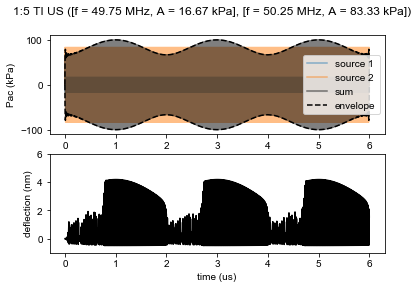

In [11]:
k = 5
label = f'1:{k} TI'
A1, A2 = getAmpPair(peak_pressure, k)
drive = AcousticDriveArray([AcousticDrive(f1, A1, phi=np.pi), AcousticDrive(f2, A2, phi=np.pi - delta_phi)])
figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

Expectedly, the greater offset in the drive envelope created by this higher ratio further attenuates the membrane compression phases in favor of expansion phases.

Hence, while preserving the maximal membrane deflection, the amplified deflection offset results in a voltage deviation of 55 mV.

### 1:10 TI ratio

Let's now try with a 1:10 ratio (i.e. 9 and 91 kPa respectively).

 10/02/2020 19:57:36: Simulating BilayerSonophore(32.0 nm) model with AcousticDriveArray(AcousticDrive(49.8MHz, 9.1kPa), AcousticDrive(50.2MHz, 90.9kPa))


Average voltage deviation from resting potential: 73.13 mV


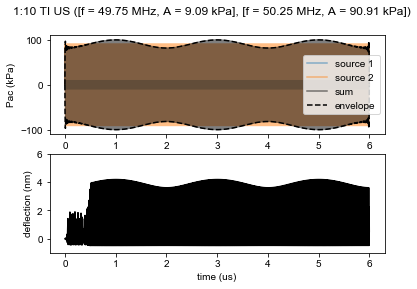

In [12]:
k = 10
label = f'1:{k} TI'
A1, A2 = getAmpPair(peak_pressure, k)
drive = AcousticDriveArray([AcousticDrive(f1, A1, phi=np.pi), AcousticDrive(f2, A2, phi=np.pi - delta_phi)])
figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

At this point, the drive envelope offset becomes more significant than its own variation. This offset is perpetuated in the membrane deflection (after an initial half-cycle of adaptation), where cyclic variations are very small compared to the deflection offset.

Notably, the resulting average voltage deviation (73 mV) now exceeds that obtained with the single acoustic drive at the envelope frequency (64 mV).

### 1:20 TI ratio

Let's now try with a 1:20 ratio (i.e. 5 and 95 kPa respectively).

 10/02/2020 19:58:25: Simulating BilayerSonophore(32.0 nm) model with AcousticDriveArray(AcousticDrive(49.8MHz, 4.8kPa), AcousticDrive(50.2MHz, 95.2kPa))


Average voltage deviation from resting potential: 76.73 mV


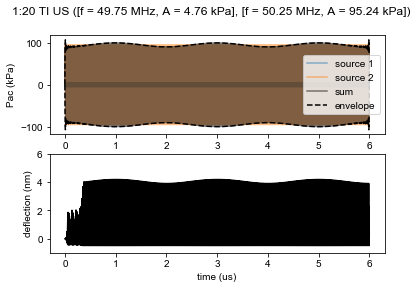

In [13]:
k = 20
label = f'1:{k} TI'
A1, A2 = getAmpPair(peak_pressure, k)
drive = AcousticDriveArray([AcousticDrive(f1, A1, phi=np.pi), AcousticDrive(f2, A2, phi=np.pi - delta_phi)])
figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

Expectedly, the drive and deflection offsets are further amplified. However, we notice little increase in the resulting average voltage deviation (76 mV), indicating that we are getting close to the maximal offset we can generate.

### Higher ratios

Let's keep increasing the ratio until we see a saturation of the average voltage deviation.

 10/02/2020 19:59:14: Simulating BilayerSonophore(32.0 nm) model with AcousticDriveArray(AcousticDrive(49.8MHz, 2.0kPa), AcousticDrive(50.2MHz, 98.0kPa))


Average voltage deviation from resting potential: 79.73 mV


 10/02/2020 19:59:53: Simulating BilayerSonophore(32.0 nm) model with AcousticDriveArray(AcousticDrive(49.8MHz, 990.1Pa), AcousticDrive(50.2MHz, 99.0kPa))


Average voltage deviation from resting potential: 79.62 mV


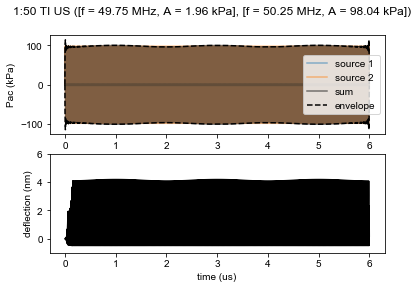

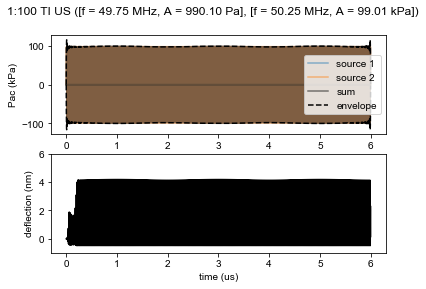

In [14]:
for k in [50, 100]:
    label = f'1:{k} TI'
    A1, A2 = getAmpPair(peak_pressure, k)
    drive = AcousticDriveArray([AcousticDrive(f1, A1, phi=np.pi), AcousticDrive(f2, A2, phi=np.pi - delta_phi)])
    figs[label], Vm_devs[label] = plotResponse(bls, drive, label)
    print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

As we can see, we seem to reach response saturation with the 1:100 ratio.

### Comparing efficiencies

In the NICE framework, the initial build-up in membrane charge density that initiates a neural response is directly driven by leakage currents, responding to the voltage deviation from its resting value induced by intramembrane cavitation. 

Moreover, assuming that the ability to bring the membrane to its spiking threshold is directly proportional to the strength of this initial charge build-up, and recalling that leakage currents mediating this build-up are proportional to the membrane voltage deviations, the latter metrics provides a good estimate of a the "relative excitation power" (or efficiency) of a given protocol.

Hence, we compare here use the efficiencies of all protocols by plotting the average voltage deviations they induced, normalized by the value obtained for the single LF drive used here as reference.

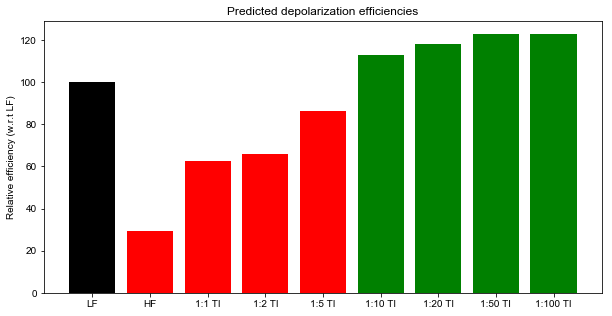

In [15]:
def plotDepEfficencies(Vm_devs, ref_key='LF'):
    ''' Plot a bar chart about the comparative depolarization efficiencies elicited
        by different acoustic drives.

        :param Vm_devs: dictionary of labels: voltage deviations (mV)
        :param ref_key: dictionary key of the normalization value
        :return: figure object
    '''
    x = np.arange(len(Vm_devs))
    y = np.array(list(Vm_devs.values()))
    yref = Vm_devs[ref_key]
    ynorm = y / yref
    colors = ['g' if yn >= 1 else 'r' for yn in ynorm]
    colors[0] = 'k'
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x, 100 * ynorm, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(list(Vm_devs.keys()))
    ax.set_ylabel(f'Relative efficiency (w.r.t {ref_key})')
    ax.set_title('Predicted depolarization efficiencies')
    return fig

figs['Vm devs'] = plotDepEfficencies(Vm_devs, ref_key='LF')

We do notice the drop in efficiency when using a single HF source, and the progressive increase with unbalanced TI sources until saturation of the protocol's efficiency with high amplitude ratios.

## Embedded bilayer sonophore model (with high-frequency damping)

Let's now check how much tissue embedding should affect our predictions. For that, we embed the same 32 nm radius bilayer sonophore inside 10 um of surrounding tissue with a frequency-dependent elastic modulus.

In [24]:
embedded_bls = bls.copy()
embedded_bls.d = 1e-6  # um

embdded_figs, embedded_Vm_devs = {}, {}

Let's also define a constant peak pressure amplitude of 500 kPa (conserved across all acoustic drives), to "compensate" for the cavitation attenuation.

In [25]:
peak_pressure = 500e3  # Pa

### Low-frequency drive

 10/02/2020 20:19:33: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDrive(500.0kHz, 500.0kPa)


Average voltage deviation from resting potential: 64.91 mV


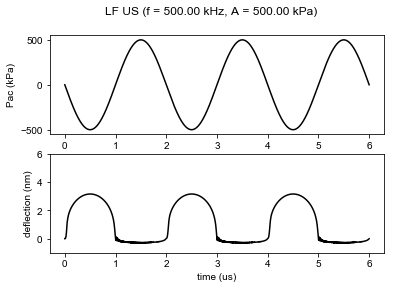

In [26]:
label = 'LF'
drive = AcousticDrive(f_low, peak_pressure)
figs[f'emb {label}'], embedded_Vm_devs[label] = plotResponse(embedded_bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

### High-frequency drive

 10/02/2020 20:19:44: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDrive(50.0MHz, 500.0kPa)


Average voltage deviation from resting potential: 19.00 mV


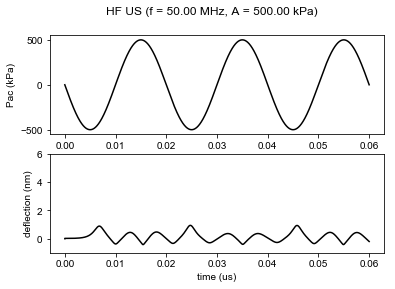

In [27]:
label = 'HF'
drive = AcousticDrive(f_high, peak_pressure)
figs[label], embedded_Vm_devs[label] = plotResponse(embedded_bls, drive, label)
print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

### TI drives

 10/02/2020 20:19:44: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDriveArray(AcousticDrive(49.8MHz, 250.0kPa), AcousticDrive(50.2MHz, 250.0kPa))


Average voltage deviation from resting potential: 40.64 mV


 10/02/2020 20:20:13: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDriveArray(AcousticDrive(49.8MHz, 166.7kPa), AcousticDrive(50.2MHz, 333.3kPa))


Average voltage deviation from resting potential: 42.68 mV


 10/02/2020 20:20:44: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDriveArray(AcousticDrive(49.8MHz, 83.3kPa), AcousticDrive(50.2MHz, 416.7kPa))


Average voltage deviation from resting potential: 55.93 mV


 10/02/2020 20:21:18: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDriveArray(AcousticDrive(49.8MHz, 45.5kPa), AcousticDrive(50.2MHz, 454.5kPa))


Average voltage deviation from resting potential: 73.13 mV


 10/02/2020 20:21:52: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDriveArray(AcousticDrive(49.8MHz, 23.8kPa), AcousticDrive(50.2MHz, 476.2kPa))


Average voltage deviation from resting potential: 76.73 mV


 10/02/2020 20:22:27: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDriveArray(AcousticDrive(49.8MHz, 9.8kPa), AcousticDrive(50.2MHz, 490.2kPa))


Average voltage deviation from resting potential: 79.73 mV


 10/02/2020 20:23:03: Simulating BilayerSonophore(32.0 nm, d=1.0 um) model with AcousticDriveArray(AcousticDrive(49.8MHz, 5.0kPa), AcousticDrive(50.2MHz, 495.0kPa))


Average voltage deviation from resting potential: 79.62 mV


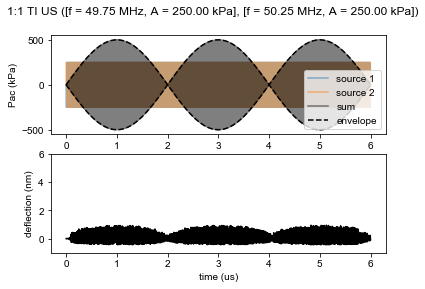

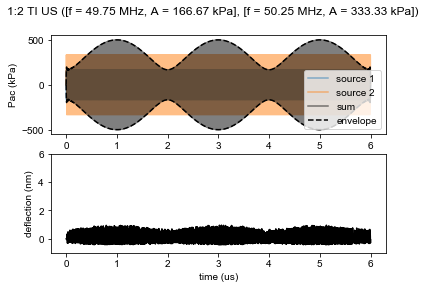

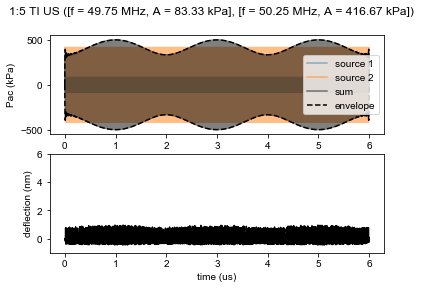

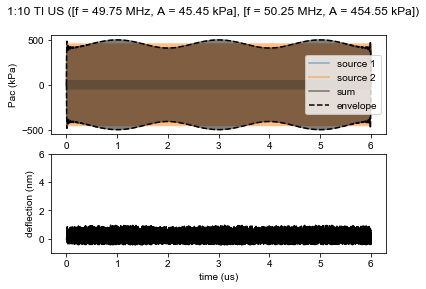

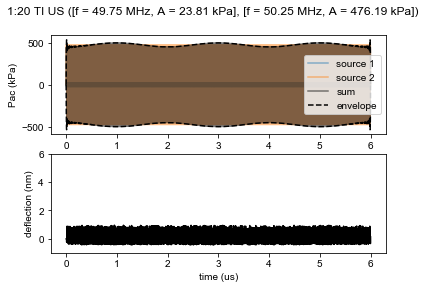

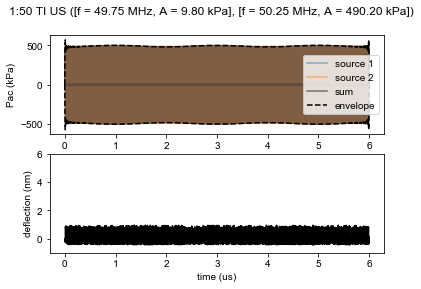

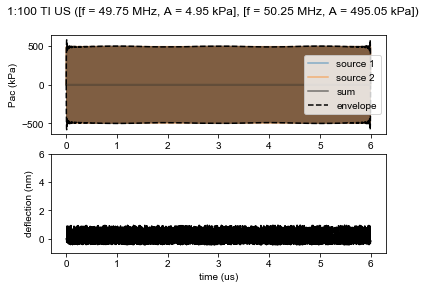

In [28]:
for k in [1, 2, 5, 10, 20, 50, 100]:
    label = f'1:{k} TI'
    A1, A2 = getAmpPair(peak_pressure, k)
    drive = AcousticDriveArray([AcousticDrive(f1, A1, phi=np.pi), AcousticDrive(f2, A2, phi=np.pi - delta_phi)])
    figs[label], embedded_Vm_devs[label] = plotResponse(embedded_bls, drive, label)
    print(f'Average voltage deviation from resting potential: {Vm_devs[label]:.2f} mV')

### Comparing efficiencies

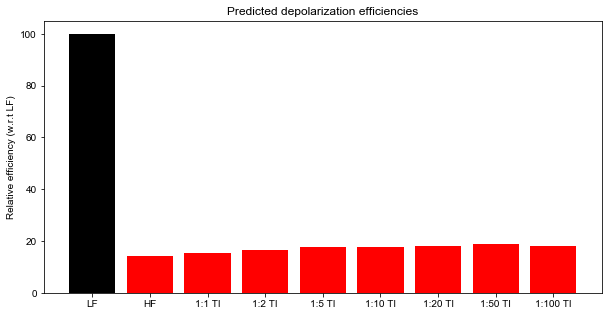

In [29]:
figs['embedded Vm devs'] = plotDepEfficencies(embedded_Vm_devs, ref_key='LF')

### Conclusions 

Model simulations show that the interference of two high-frequency waves of equal amplitude can generate a low-frequency envelope of cavitation in the neuron membrane in order to induce depolarization. Furthermore, by modulating the ratio of intensity of the two high-frequency sources, we could induce an offset in the cavitation envelope, which enhances the depolarization efficiency to values that can exceed those obtained with a single low-frequency source.

### Save figures as PNGs

In [31]:
root = input('Please specify the output directory:')
if len(root) > 0:
    for k, fig in figs.items():
        k = k.replace(':', '-').replace(' ', '_')
        fig.savefig(os.path.join(root, f'{k}.png'))
    for k, fig in embedded_figs.items():
        k = k.replace(':', '-').replace(' ', '_')
        fig.savefig(os.path.join(root, f'{k}.png'))

Please specify the output directory: 
